In [ ]:
%load_ext autoreload

In [1]:
import torch
from dataloader import sarDataLoader
from model import sarInferenceModel
from rasterio.merge import merge
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
from pathlib import Path
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from rasterio.warp import transform_bounds
from rasterio.transform import array_bounds
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from tools import denoise

/u/k-data/karthikv/mambaforge/envs/opera-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/data/new_cnn_training_data/chips/training_data.csv')
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head()

In [ ]:
len(df)

In [ ]:
# replace paths in df with absolute paths
def replace_with_abs_path(path_str):
    if isinstance(path_str, int):
        return path_str
    
    abs_path = '/u/leffe-data2/karthikv/rfs-and-cnns'
    return path_str.replace('..', abs_path)

test_df = df.applymap(replace_with_abs_path)

In [ ]:
dataloader = sarDataLoader(x_paths = test_df.drop(["labels"], axis=1), y_paths=test_df[["labels"]], return_hand=False)
img_stack, label, profile = dataloader.__getitem__(idx=150, inference=True)
# img_stack, label = dataloader.__getitem__(idx=1000)
label = np.clip(label, 0, 2)

src_crs = profile['crs']
dst_crs = CRS.from_epsg(4326)

# imshow_bounds

In [ ]:
img_bounds = array_bounds(512, 512, profile['transform'])
img_bounds_4326 = transform_bounds(src_crs, dst_crs, *img_bounds)
# center_lat = 0.5*(img_bounds_4326[1] + img_bounds_4326[3])
# x_res = np.rad2deg(25./(6378)*np.cos(np.deg2rad(center_lat)))


In [ ]:
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen", "white"])

fig, axs = plt.subplots(2, 4, figsize=(40, 20), layout='constrained')

# Row 1
im = axs[0][0].imshow(img_stack[0], cmap='gray')
axs[0][0].set_title('ALOS HH image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 0], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=25)
cbar.ax.tick_params(labelsize=25)

scalebar = AnchoredSizeBar(axs[0][0].transData,
                           80, '1 km', 'upper left', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':32, 'weight':'heavy'},
                           size_vertical=10)
axs[0][0].add_artist(scalebar)
axs[0][0].set_xticks([])
axs[0][0].set_yticks([])

im = axs[0][1].imshow(img_stack[1], vmax=0.05, cmap='gray')
axs[0][1].set_title('ALOS HV image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 1], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])

im = axs[0][2].imshow(img_stack[2], cmap='Reds')
axs[0][2].set_title('Red channel', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 2], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[0][2].set_xticks([])
axs[0][2].set_yticks([])

im = axs[0][3].imshow(img_stack[3], cmap='YlOrRd')
axs[0][3].set_title('NIR channel', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 3], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[0][3].set_xticks([])
axs[0][3].set_yticks([])

# Row 2
im = axs[1][0].imshow(img_stack[4], cmap='Oranges')
axs[1][0].set_title('SWIR1 image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 0], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])

im = axs[1][1].imshow(img_stack[5], cmap='Oranges')
axs[1][1].set_title('SWIR2 image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 1], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])

im = axs[1][2].imshow(img_stack[6], cmap='plasma')
axs[1][2].set_title('DEM', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 2], fraction = 0.05)
cbar.set_label('meters', fontsize=25)
cbar.ax.tick_params(labelsize=25)
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])

im = axs[1][3].imshow(label, cmap=inferencemap)
axs[1][3].set_title('USGS DSWE Labels', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 3], fraction = 0.05, ticks=[0.25, 1, 1.75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater', 'No data'], fontsize=25)
# axs[1][3].set_xlabel('Pixels', fontsize=28)
# axs[1][3].set_ylabel('Pixels', fontsize=28)
axs[1][3].set_xticks([])
axs[1][3].set_yticks([])

for i in range(2):
    for j in range(4):
        axs[i, j].xaxis.set_tick_params(labelsize=25)
        axs[i, j].yaxis.set_tick_params(labelsize=25)

In [ ]:
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen", "white"])

fig, axs = plt.subplots(2, 4, figsize=(40, 20), layout='constrained')

# Row 1
im = axs[0][0].imshow(img_stack[0], cmap='gray')
axs[0][0].set_title('ALOS HH image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 0], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=25)
cbar.ax.tick_params(labelsize=25)

scalebar = AnchoredSizeBar(axs[0][0].transData,
                           80, '1 km', 'lower left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':24, 'weight':'heavy'},
                           size_vertical=10)
axs[0][0].add_artist(scalebar)

im = axs[0][1].imshow(img_stack[1], vmax=0.05, cmap='gray')
axs[0][1].set_title('ALOS HV image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 1], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=25)
cbar.ax.tick_params(labelsize=25)

im = axs[0][2].imshow(img_stack[2], cmap='Reds')
axs[0][2].set_title('Red channel', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 2], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)

im = axs[0][3].imshow(img_stack[3], cmap='YlOrRd')
axs[0][3].set_title('NIR channel', fontsize=35)
cbar = fig.colorbar(im, ax=axs[0, 3], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)

# Row 2
im = axs[1][0].imshow(img_stack[4], cmap='Oranges')
axs[1][0].set_title('SWIR1 image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 0], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)

im = axs[1][1].imshow(img_stack[5], cmap='Oranges')
axs[1][1].set_title('SWIR2 image', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 1], fraction = 0.05)
cbar.set_label('DN', fontsize=25)
cbar.ax.tick_params(labelsize=25)

im = axs[1][2].imshow(img_stack[6], cmap='plasma')
axs[1][2].set_title('DEM', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 2], fraction = 0.05)
cbar.set_label('meters', fontsize=25)
cbar.ax.tick_params(labelsize=25)

im = axs[1][3].imshow(label, cmap=inferencemap)
axs[1][3].set_title('USGS DSWE Labels', fontsize=35)
cbar = fig.colorbar(im, ax=axs[1, 3], fraction = 0.05, ticks=[0.25, 1, 1.75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater', 'No data'], fontsize=25)

for i in range(2):
    for j in range(4):
        axs[i, j].xaxis.set_tick_params(labelsize=25)
        axs[i, j].yaxis.set_tick_params(labelsize=25)


In [ ]:
# weights_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/notebooks/model-outputs/01022023_a.pt')
weights_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/notebooks/model-outputs/02252023_a.pt')

model_params = {
    "sarData":True,
    "denoisingWeight":0.35,
    "opticalData":True,
    "demData":True,
    "handData":False,
    "output_classes":2,
    "backbone" : "resnet50",
    "gpu": True
}

model = sarInferenceModel(model_params)
model.load_state_dict(torch.load(f"{weights_path}"), strict=False)
model.model.eval()

In [ ]:
outputs = model.forward(torch.tensor(img_stack.reshape(1, *img_stack.shape)).cuda())
outputs = torch.argmax(torch.squeeze(outputs), dim=0)
sar_and_optical_outputs = outputs.cpu().numpy()

In [ ]:
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen"])
fig, ax = plt.subplots(1, 1, figsize=(10, 10), layout='constrained')
im = ax.imshow(sar_and_optical_outputs, cmap=inferencemap)
ax.set_title('SAR + Optical inferences', fontsize=35)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
cbar = fig.colorbar(im, ax=ax, fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=25)

In [ ]:
dataloader = sarDataLoader(x_paths = test_df.drop(["labels"], axis=1), y_paths=test_df[["labels"]], return_optical=False, return_hand=False)
img_stack, label = dataloader.__getitem__(idx=150)
# img_stack = img_stack.reshape(1, *img_stack.shape)
# print(img_stack.shape)
# img_stack = np.stack([img_stack[0], img_stack[1], img_stack[6]], axis=0)
label = np.clip(label, 0, 2)

In [ ]:
# weights_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/notebooks/model-outputs/01022023_b.pt')
weights_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/notebooks/model-outputs/02272023_a.pt')

model_params = {
    "sarData":True,
    "denoisingWeight":0.35,
    "opticalData":False,
    "demData":True,
    "handData":False,
    "output_classes":2,
    "backbone" : "resnet50",
    "gpu": True
}

model = sarInferenceModel(model_params)
model.load_state_dict(torch.load(f"{weights_path}"), strict=False)
model.model.eval()  

In [ ]:
outputs = model.forward(torch.tensor(img_stack.reshape(1, *img_stack.shape)).cuda())
outputs = torch.argmax(torch.squeeze(outputs), dim=0)
sar_only_outputs = outputs.cpu().numpy()

In [ ]:
# Combine above plots into one
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen"])
fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout='constrained')
im = ax[0].imshow(sar_and_optical_outputs, cmap=inferencemap)
ax[0].set_title('SAR+Optical inferences', fontsize=35)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(sar_only_outputs, cmap=inferencemap)
ax[1].set_title('SAR only inferences', fontsize=35)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)
ax[1].set_xticks([])
ax[1].set_yticks([])

cbar = fig.colorbar(im, ax=ax[1], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=25)

scalebar = AnchoredSizeBar(ax[0].transData,
                           80, '1 km', 'upper left', 
                           pad=0.5,
                           color='black',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':32, 'weight':'heavy'},
                           size_vertical=10)
ax[0].add_artist(scalebar)


In [ ]:
print(sar_and_optical_outputs.shape, sar_only_outputs.shape)

In [ ]:
# Combine above plots into one
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen"])
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

im = ax[0].imshow(sar_and_optical_outputs, cmap=inferencemap, aspect='equal')
ax[0].set_title('SAR+Optical inferences', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=20)
ax[0].yaxis.set_tick_params(labelsize=20)

im = ax[1].imshow(sar_only_outputs, cmap=inferencemap, aspect='equal')
ax[1].set_title('SAR only inferences', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=20)
ax[1].yaxis.set_tick_params(labelsize=20)

# cbar = fig.colorbar(im, ax=ax[1], fraction = 0.05, ticks=[0.25, .75])
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.895, 0.155, 0.01, 0.685])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0.25, .75]) # # cbar =
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=20)
# plt.tight_layout(rect=(0.1, 0.1, 0.8, 0.8))

To create a time series plot, we'll generate inferences using the Anaurilandia data. The way to create this figure is to perform inferences across the scene and then read only a window defined by user-provided bounds

In [ ]:
# the images in ts1 combined together defines the consistent bounds over which we'll create plots 
ts_path = Path('../data/ts')
left, bottom, right, top = None, None, None, None
for f in list(ts_path.glob('*.tif')):
    with rasterio.open(f) as ds:
        bounds = ds.bounds
        og_crs = ds.crs
    
    left = bounds[0] if left is None else bounds[0] if left > bounds[0] else left
    bottom = bounds[1] if bottom is None else bounds[1] if bottom > bounds[1] else bottom
    right = bounds[2] if right is None else bounds[2] if right < bounds[2] else right
    top = bounds[3] if top is None else bounds[3] if top < bounds[3] else top

op_bounds = (left, bottom, right, top)
new_bounds1 = transform_bounds(og_crs, CRS.from_epsg(4326), *op_bounds)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout='constrained')

img, _ = merge(['../data/hh_data/AP_07366_FBD_F7140_RT1_HH.tif'], bounds=op_bounds)
inf, _ = merge(['../data/02252023_a_merged_inferences_07366.tif'], bounds=op_bounds)
mask = np.where(np.squeeze(img) == 0, np.nan, 1)

img = np.squeeze(img)*mask
inf = np.squeeze(inf)*mask

im = ax[0].imshow(img, vmax=0.45, cmap='gray')
cbar = plt.colorbar(im, ax=ax[0], fraction=0.05)
cbar.set_label('Backscatter ($\gamma_0$)', fontsize=22)
cbar.ax.tick_params(labelsize=15)
ax[0].set_title('SAR HH image (06/13/07)', fontsize=30)
ax[0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[0].set_xlabel('Longitude (degrees)', fontsize=28)
ax[0].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)

scalebar = AnchoredSizeBar(ax[0].transData,
                           240, '3 km', 'upper left', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':32, 'weight':'heavy'},
                           size_vertical=10)
ax[0].add_artist(scalebar)

im = ax[1].imshow(inf, cmap=inferencemap)
cbar = fig.colorbar(im, ax=ax[1], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=25)

ax[1].set_title('Model inference (06/13/07)', fontsize=30)
ax[1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[1].set_xlabel('Longitude (degrees)', fontsize=28)
ax[1].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)

fig.savefig('../figures/anaurilandia_ts_0.png', facecolor='white', transparent=False)
#####

fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout='constrained')

img, _ = merge(['../data/hh_data/AP_08037_FBD_F7140_RT1_HH.tif'], bounds=op_bounds)
inf, _ = merge(['../data/02252023_a_merged_inferences_08037.tif'], bounds=op_bounds)
mask = np.where(np.squeeze(img) == 0, np.nan, 1)

img = np.squeeze(img)*mask
inf = np.squeeze(inf)*mask

mask = np.where(np.squeeze(img) == 0, np.nan, 1)
im = ax[0].imshow(img, vmax=0.45, cmap='gray')
cbar = plt.colorbar(im, ax=ax[0], fraction=0.05)
cbar.set_label('Backscatter ($\gamma_0$)', fontsize=22)
cbar.ax.tick_params(labelsize=15)
ax[0].set_title('SAR HH image (07/29/07)', fontsize=30)
ax[0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[0].set_xlabel('Longitude (degrees)', fontsize=28)
ax[0].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)

im = ax[1].imshow(inf, cmap=inferencemap)
cbar = fig.colorbar(im, ax=ax[1], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=25)
ax[1].set_title('Model inference (07/29/07)', fontsize=30)
ax[1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[1].set_xlabel('Longitude (degrees)', fontsize=28)
ax[1].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)


fig.savefig('../figures/anaurilandia_ts_1.png', facecolor='white', transparent=False)
#####

fig, ax = plt.subplots(1, 2, figsize=(20, 10), layout='constrained')

img, _ = merge(['../data/hh_data/AP_08708_FBD_F7140_RT1_HH.tif'], bounds=op_bounds)
inf, _ = merge(['../data/02252023_a_merged_inferences_08708.tif'], bounds=op_bounds)
mask = np.where(np.squeeze(img) == 0, np.nan, 1)

img = np.squeeze(img)*mask
inf = np.squeeze(inf)*mask

mask = np.where(np.squeeze(img) == 0, np.nan, 1)
im = ax[0].imshow(img, vmax=0.45, cmap='gray')
cbar = plt.colorbar(im, ax=ax[0], fraction=0.05)
cbar.set_label('Backscatter ($\gamma_0$)', fontsize=22)
cbar.ax.tick_params(labelsize=15)
ax[0].set_title('SAR HH image (09/13/07)', fontsize=30)
ax[0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[0].set_xlabel('Longitude (degrees)', fontsize=28)
ax[0].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)

im = ax[1].imshow(inf, cmap=inferencemap)
cbar = fig.colorbar(im, ax=ax[1], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=25)
ax[1].set_title('Model inference (09/13/07)', fontsize=30)
ax[1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=18)
ax[1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=18)
ax[1].set_xlabel('Longitude (degrees)', fontsize=28)
ax[1].set_ylabel('Latitude (degrees)', fontsize=28, labelpad=-35)

fig.savefig('../figures/anaurilandia_ts_2.png', facecolor='white', transparent=False)

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20)) #, layout='constrained'

fig.tight_layout(pad=10.0)

img, _ = merge(['../data/hh_data/AP_07366_FBD_F7140_RT1_HH.tif'], bounds=op_bounds)
inf, _ = merge(['../data/02252023_a_merged_inferences_07366.tif'], bounds=op_bounds)
mask = np.where(np.squeeze(img) == 0, np.nan, 1)

img = np.squeeze(img)*mask
inf = np.squeeze(inf)*mask

im = ax[0][0].imshow(img, vmax=0.45, cmap='gray')
cbar = plt.colorbar(im, ax=ax[0][0], fraction=0.04)
cbar.set_label('Backscatter ($\gamma_0$)', fontsize=22)
cbar.ax.tick_params(labelsize=15)
ax[0][0].set_title('SAR HH image (06/13/07)', fontsize=24)
ax[0][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

im = ax[0][1].imshow(inf, cmap=inferencemap)
cbar = fig.colorbar(im, ax=ax[0][1], fraction = 0.04, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=22)

ax[0][1].set_title('Model inference (06/13/07)', fontsize=24)
ax[0][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

img, _ = merge(['../data/hh_data/AP_08708_FBD_F7140_RT1_HH.tif'], bounds=op_bounds)
inf, _ = merge(['../data/02252023_a_merged_inferences_08708.tif'], bounds=op_bounds)
mask = np.where(np.squeeze(img) == 0, np.nan, 1)

img = np.squeeze(img)*mask
inf = np.squeeze(inf)*mask

mask = np.where(np.squeeze(img) == 0, np.nan, 1)
im = ax[1][0].imshow(img, vmax=0.45, cmap='gray')
cbar = plt.colorbar(im, ax=ax[1][0], fraction=0.04)
cbar.set_label('Backscatter ($\gamma_0$)', fontsize=22)
cbar.ax.tick_params(labelsize=15)
ax[1][0].set_title('SAR HH image (09/13/07)', fontsize=24)
ax[1][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

im = ax[1][1].imshow(inf, cmap=inferencemap)
cbar = fig.colorbar(im, ax=ax[1][1], fraction = 0.04, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=22)
ax[1][1].set_title('Model inference (09/13/07)', fontsize=24)
ax[1][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

fig.savefig('../figures/combined_inferences.png', facecolor='white', transparent=False)

### Figures for Oneida, NY

In [2]:
data_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/data/scenes/oneida_ny/validation.csv')
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)


# replace paths in df with absolute paths
def replace_with_abs_path(path_str):
    if isinstance(path_str, int):
        return path_str
    
    abs_path = '/u/leffe-data2/karthikv/rfs-and-cnns'
    return path_str.replace('..', abs_path)

test_df = df.applymap(replace_with_abs_path)

dataloader = sarDataLoader(x_paths = test_df.drop(["labels"], axis=1), y_paths=test_df[["labels"]], return_hand=False)


In [4]:
idxs = [39, 40, 51, 52]

hh_list = [test_df.iloc[x].hh for x in idxs]
red_list = [test_df.iloc[x].red for x in idxs]
swir1_list = [test_df.iloc[x].swir1 for x in idxs]
swir2_list = [test_df.iloc[x].swir2 for x in idxs]

inf_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/data/scenes/oneida_ny/inferences/02252023_a')
inference_list = [inf_path / f"inference_{str(x).zfill(5)}.tiff" for x in idxs]
inference_c_list = [inf_path / f"confidence_inference_{str(x).zfill(5)}.tiff" for x in idxs]

In [40]:
left, bottom, right, top = None, None, None, None
for f in hh_list:
    with rasterio.open(f) as ds:
        bounds = ds.bounds
        og_crs = ds.crs
    
    left = bounds[0] if left is None else bounds[0] if left > bounds[0] else left
    bottom = bounds[1] if bottom is None else bounds[1] if bottom > bounds[1] else bottom
    right = bounds[2] if right is None else bounds[2] if right < bounds[2] else right
    top = bounds[3] if top is None else bounds[3] if top < bounds[3] else top

op_bounds = (left, bottom, right, top)
new_bounds1 = transform_bounds(og_crs, CRS.from_epsg(4326), *op_bounds)

In [26]:
hh_img, _ = merge(hh_list)
hh_img = denoise(np.squeeze(hh_img), weight=0.35, input_db=False, return_db=True)

red_img, _ = merge(red_list)
swir1_img, _ = merge(swir1_list)
swir2_img, _ = merge(swir2_list)
falsecolor_stack = np.concatenate([red_img, swir1_img, swir2_img], axis=0).transpose([1, 2, 0])

inf_img, _ = merge(inference_list)
inf_img = np.squeeze(inf_img)
inf_c_img, _ = merge(inference_c_list)
inf_c_img = np.squeeze(inf_c_img)

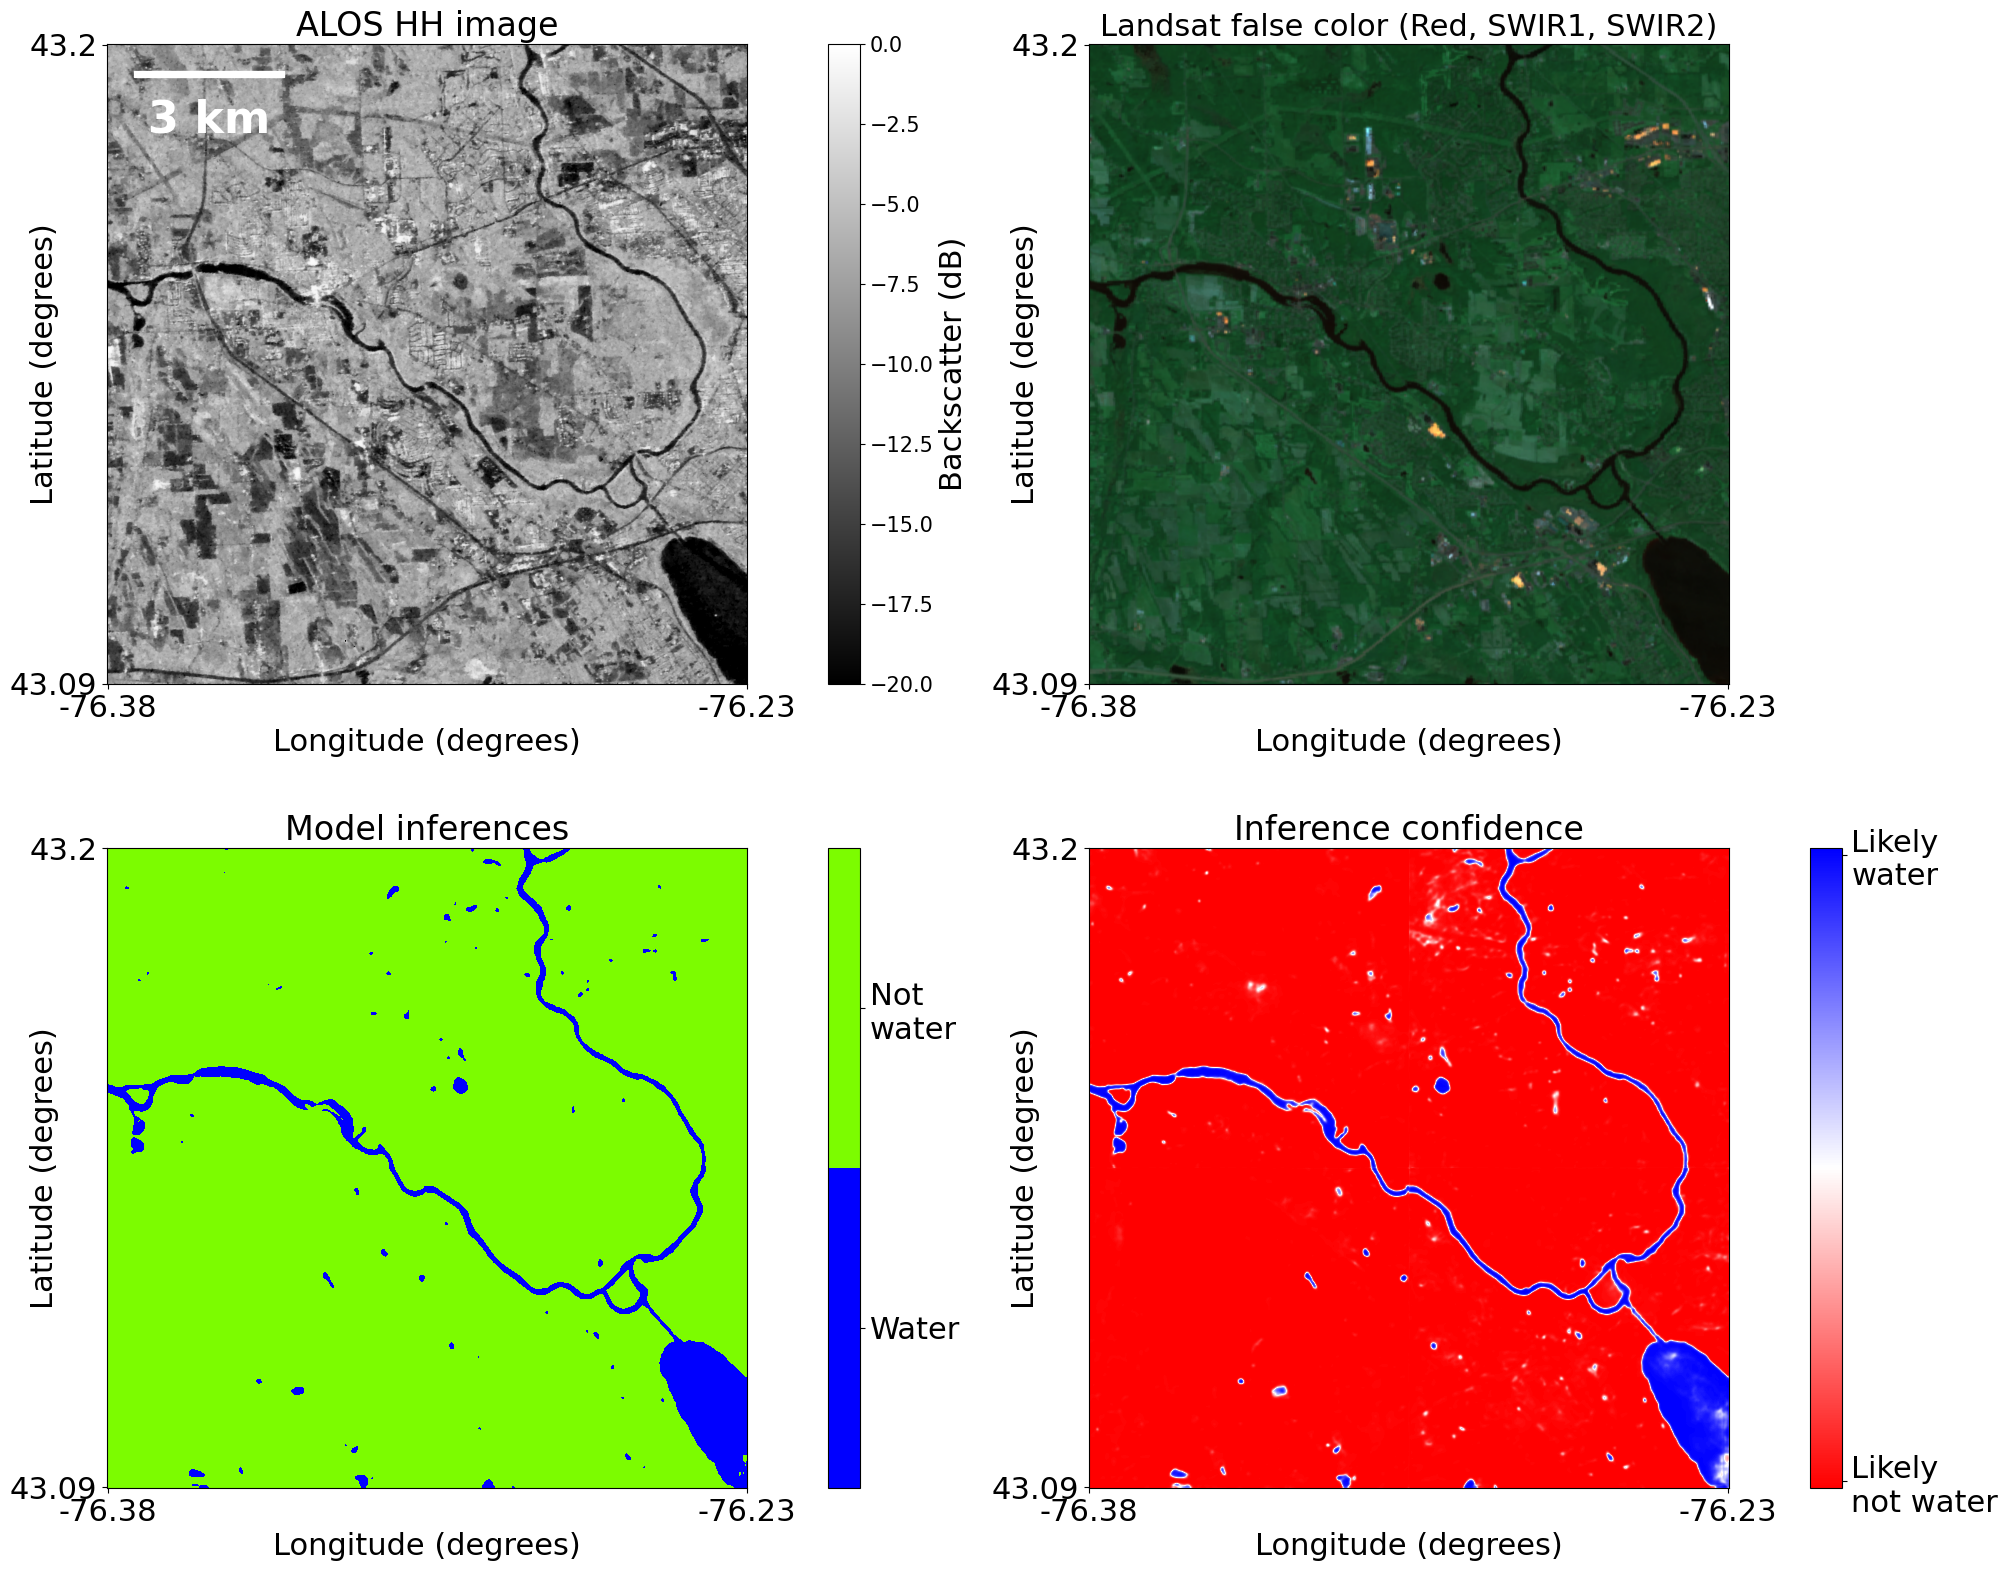

In [73]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16), layout='constrained') #
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen"])

im = ax[0][0].imshow(hh_img, cmap='gray', vmin=-20, vmax=0)

scalebar = AnchoredSizeBar(ax[0][0].transData,
                           240, '3 km', 'upper left', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':32, 'weight':'heavy'},
                           size_vertical=10)
ax[0][0].add_artist(scalebar)
ax[0][0].set_title('ALOS HH image', fontsize=24)

ax[0][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

cbar = fig.colorbar(im, ax=ax[0][0], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=22)
cbar.ax.tick_params(labelsize=15)

ax[0][1].imshow(falsecolor_stack)
ax[0][1].set_title('Landsat false color (Red, SWIR1, SWIR2)', fontsize=22)

ax[0][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)


im = ax[1][0].imshow(inf_img, cmap=inferencemap)
ax[1][0].set_title('Model inferences', fontsize=24)
cbar = fig.colorbar(im, ax=ax[1][0], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=22)

ax[1][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

im = ax[1][1].imshow(inf_c_img, cmap='bwr_r')
ax[1][1].set_title('Inference confidence', fontsize=24)
cbar = fig.colorbar(im, ax=ax[1][1], fraction = 0.05, ticks=[1, 99])
cbar.ax.set_yticklabels(['Likely \nnot water', 'Likely \nwater'], fontsize=22)

ax[1][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

# fig.subplots_adjust(hspace=0.05)
# fig.subplots_adjust(wspace=0.4)
# plt.tight_layout()

fig.savefig('../figures/oneida_inferences.png', facecolor='white', transparent=False)


### Figures for Galveston, TX

In [74]:
data_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/data/scenes/galveston_tx/validation.csv')
df = pd.read_csv(data_path)
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)


# replace paths in df with absolute paths
def replace_with_abs_path(path_str):
    if isinstance(path_str, int):
        return path_str
    
    abs_path = '/u/leffe-data2/karthikv/rfs-and-cnns'
    return path_str.replace('..', abs_path)

test_df = df.applymap(replace_with_abs_path)

dataloader = sarDataLoader(x_paths = test_df.drop(["labels"], axis=1), y_paths=test_df[["labels"]], return_hand=False)

In [75]:
idxs = [40, 41, 52, 53]

hh_list = [test_df.iloc[x].hh for x in idxs]
red_list = [test_df.iloc[x].red for x in idxs]
swir1_list = [test_df.iloc[x].swir1 for x in idxs]
swir2_list = [test_df.iloc[x].swir2 for x in idxs]

inf_path = Path('/u/leffe-data2/karthikv/rfs-and-cnns/data/scenes/galveston_tx/inferences/02112023_a')
inference_list = [inf_path / f"inference_{str(x).zfill(5)}.tiff" for x in idxs]
inference_c_list = [inf_path / f"confidence_inference_{str(x).zfill(5)}.tiff" for x in idxs]

In [76]:
hh_img, _ = merge(hh_list)
hh_img = denoise(np.squeeze(hh_img), weight=0.35, input_db=False, return_db=True)

red_img, _ = merge(red_list)
swir1_img, _ = merge(swir1_list)
swir2_img, _ = merge(swir2_list)
falsecolor_stack = np.concatenate([red_img, swir1_img, swir2_img], axis=0).transpose([1, 2, 0])

inf_img, _ = merge(inference_list)
inf_img = np.squeeze(inf_img)
inf_c_img, _ = merge(inference_c_list)
inf_c_img = np.squeeze(inf_c_img)

In [77]:
left, bottom, right, top = None, None, None, None
for f in hh_list:
    with rasterio.open(f) as ds:
        bounds = ds.bounds
        og_crs = ds.crs
    
    left = bounds[0] if left is None else bounds[0] if left > bounds[0] else left
    bottom = bounds[1] if bottom is None else bounds[1] if bottom > bounds[1] else bottom
    right = bounds[2] if right is None else bounds[2] if right < bounds[2] else right
    top = bounds[3] if top is None else bounds[3] if top < bounds[3] else top

op_bounds = (left, bottom, right, top)
new_bounds1 = transform_bounds(og_crs, CRS.from_epsg(4326), *op_bounds)

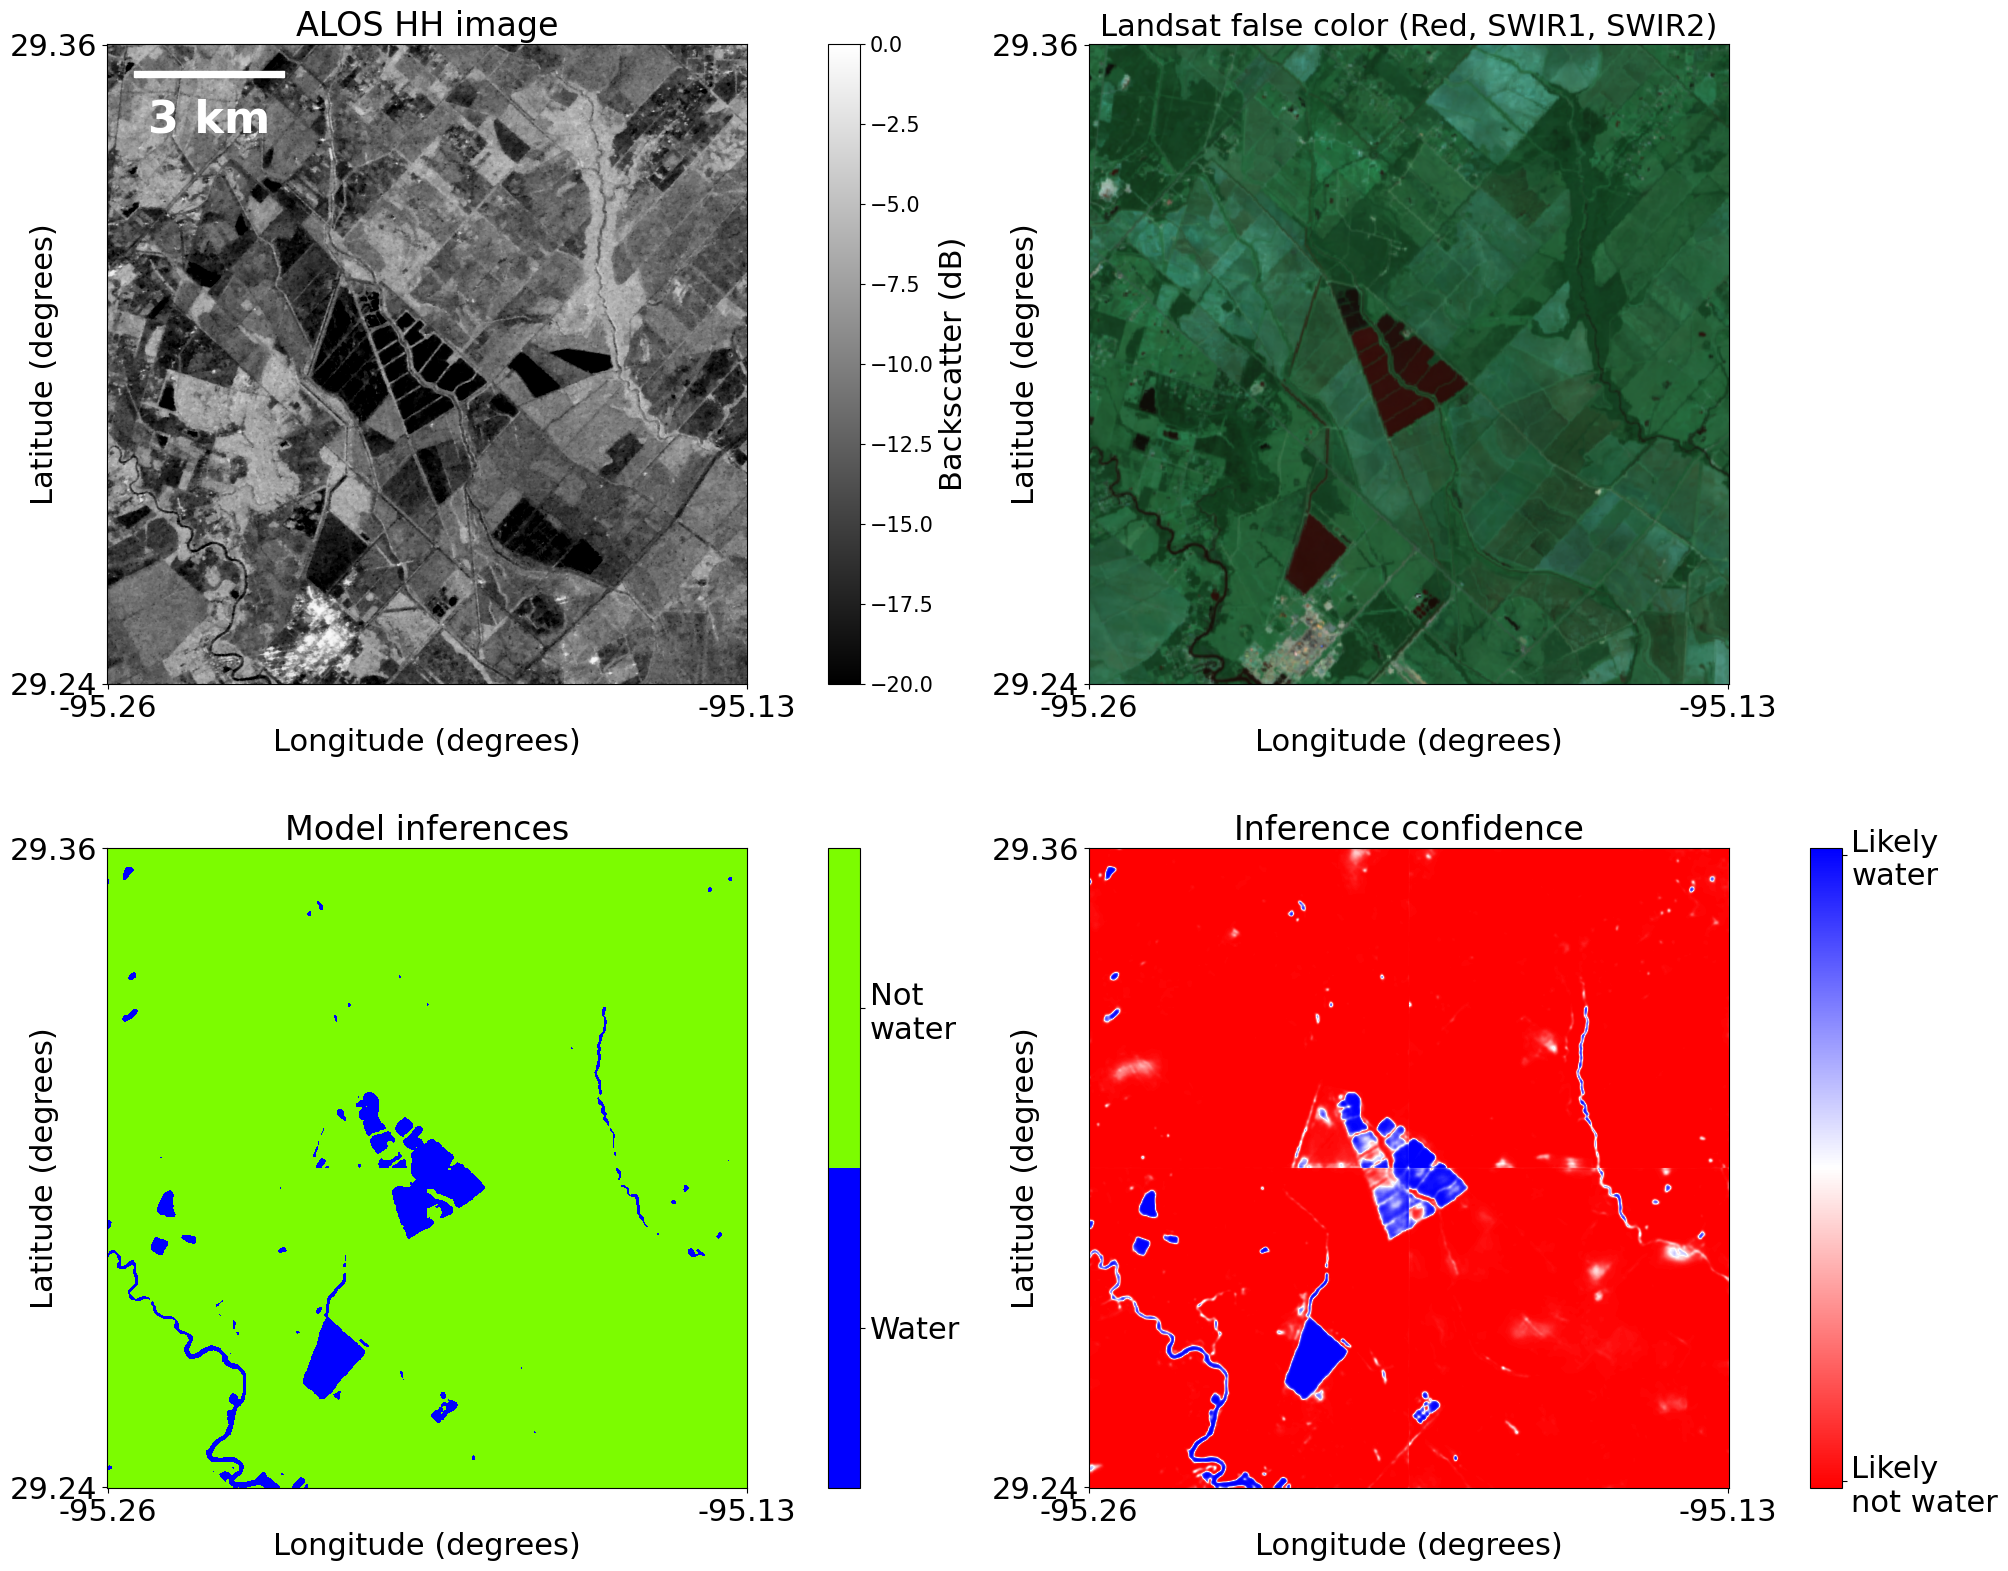

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(20, 16), layout='constrained') #
inferencemap = mpl.colors.ListedColormap(["blue", "lawngreen"])

im = ax[0][0].imshow(hh_img, cmap='gray', vmin=-20, vmax=0)

scalebar = AnchoredSizeBar(ax[0][0].transData,
                           240, '3 km', 'upper left', 
                           pad=0.5,
                           color='white',
                           frameon=False,
                           sep=15,
                           fontproperties={'size':32, 'weight':'heavy'},
                           size_vertical=10)
ax[0][0].add_artist(scalebar)
ax[0][0].set_title('ALOS HH image', fontsize=24)

ax[0][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

cbar = fig.colorbar(im, ax=ax[0][0], fraction = 0.05)
cbar.set_label('Backscatter (dB)', fontsize=22)
cbar.ax.tick_params(labelsize=15)

ax[0][1].imshow(falsecolor_stack)
ax[0][1].set_title('Landsat false color (Red, SWIR1, SWIR2)', fontsize=22)

ax[0][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[0][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[0][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[0][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)


im = ax[1][0].imshow(inf_img, cmap=inferencemap)
ax[1][0].set_title('Model inferences', fontsize=24)
cbar = fig.colorbar(im, ax=ax[1][0], fraction = 0.05, ticks=[0.25, .75])
cbar.ax.set_yticklabels(['Water', 'Not \nwater'], fontsize=22)

ax[1][0].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][0].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][0].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][0].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

im = ax[1][1].imshow(inf_c_img, cmap='bwr_r')
ax[1][1].set_title('Inference confidence', fontsize=24)
cbar = fig.colorbar(im, ax=ax[1][1], fraction = 0.05, ticks=[1, 99])
cbar.ax.set_yticklabels(['Likely \nnot water', 'Likely \nwater'], fontsize=22)

ax[1][1].set_xticks([0, 1023], [str(round(new_bounds1[0], 2)), str(round(new_bounds1[2], 2))], fontsize=22)
ax[1][1].set_yticks([0, 1023], [str(round(new_bounds1[3], 2)), str(round(new_bounds1[1], 2))], fontsize=22)
ax[1][1].set_xlabel('Longitude (degrees)', fontsize=22)
ax[1][1].set_ylabel('Latitude (degrees)', fontsize=22, labelpad=-35)

# fig.subplots_adjust(hspace=0.05)
# fig.subplots_adjust(wspace=0.4)
# plt.tight_layout()

fig.savefig('../figures/galveston_inferences.png', facecolor='white', transparent=False)